# Vehicle Damage Insurance Verification

Dataset: https://www.kaggle.com/datasets/sudhanshu2198/ripik-hackfest

Code by: Tiara Tatyanadewi Benjamin

In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


--2024-05-11 06:40:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-11 06:40:19 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
unzip_data("/content/drive/MyDrive/car.zip")

In [5]:
import pandas as pd

label_to_cls={1:"crack",
              2:"scratch",
              3:"tire flat",
              4:"dent",
              5:"glass shatter",
              6:"lamp broken"}

cls_to_label={"crack":1,
              "scratch":2,
              "tire flat":3,
              "dent":4,
              "glass shatter":5,
              "lamp broken":6}

data=pd.read_csv("/content/train/train/train.csv")
data["label"]=data["label"]
data

,image_id,filename,label
0,1,1.jpg,2
1,2,2.jpg,4
2,3,3.jpg,2
3,4,4.jpg,3
4,5,5.jpg,5
...,...,...,...
7195,7196,7196.jpg,4
7196,7197,7197.jpg,4
7197,7198,7198.jpg,4
7198,7199,7199.jpg,2


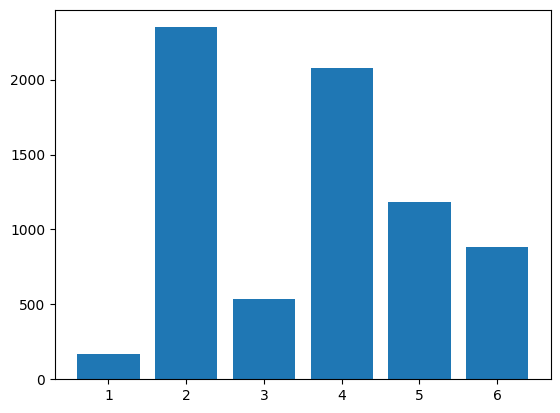

In [ ]:
import matplotlib.pyplot as plt

ser=data["label"].value_counts()
plt.bar(ser.index,ser.values);

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,classification_report
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("darkgrid")

In [ ]:
train_images = "/content/train/train/images/"
test_images = "/content/test/test/images"

In [ ]:
train_images

'/content/train/train/images/'

In [ ]:
import pandas as pd
import os
import shutil


label_df = pd.read_csv("/content/train/train/train.csv")


train_images_dir = "/content/train/train/images"
test_images_dir = "/content/test/test/images"


for idx, row in label_df.iterrows():
    filename = row["filename"]
    label = row["label"]
    label_class = label_to_cls[label]

    if filename.startswith("train"):
        img_path = os.path.join(train_images_dir, filename)
        dest_dir = os.path.join(train_images_dir, label_class)
    elif filename.startswith("test"):
        img_path = os.path.join(test_images_dir, filename)
        dest_dir = os.path.join(test_images_dir, label_class)
    else:
        continue


    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)


    shutil.copy2(img_path, dest_dir)


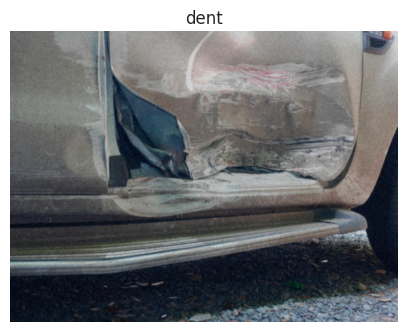

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import random


train_images_dir = "/content/train/train/images"


labels_df = pd.read_csv("/content/train/train/train.csv")

random_row = labels_df.sample()


image_file = random_row["filename"].values[0]
label = random_row["label"].values[0]


label_class = label_to_cls[label]


image_path = os.path.join(train_images_dir, image_file)


plt.figure(figsize=(5, 5))
img = plt.imread(image_path)
plt.imshow(img)
plt.title(label_class)
plt.axis('off')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, csv_file, images_dir, batch_size, img_height, img_width):
        self.csv_file = csv_file
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.df = pd.read_csv(csv_file)
        self.num_samples = len(self.df)

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, self.num_samples)

        batch_data = self.df.iloc[start_index:end_index]
        batch_images = []
        batch_labels = []

        for _, row in batch_data.iterrows():
            image_path = row['filename']
            label = row['label']

            # Load and preprocess image
            image = load_img(os.path.join(self.images_dir, image_path), target_size=(self.img_height, self.img_width))
            image = img_to_array(image) / 255.0

            batch_images.append(image)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)

train_csv_file = "/content/train/train/train.csv"
train_images_dir = "/content/train/train/images"
batch_size = 32
img_height, img_width = 224, 224

train_generator = CustomDataGenerator(train_csv_file, train_images_dir, batch_size, img_height, img_width)




In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

class CustomTestDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_dir, batch_size, img_height, img_width):
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.image_filenames = os.listdir(images_dir)
        self.num_samples = len(self.image_filenames)

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, self.num_samples)

        batch_image_filenames = self.image_filenames[start_index:end_index]
        batch_images = []

        for filename in batch_image_filenames:
            # Load and preprocess image
            img = load_img(os.path.join(self.images_dir, filename), target_size=(self.img_height, self.img_width))
            img_array = img_to_array(img) / 255.0

            batch_images.append(img_array)

        return np.array(batch_images)

# Define parameters
test_images_dir = "/content/test/test/images"
batch_size = 32
img_height, img_width = 224, 224  # Image dimensions

# Create custom test data generator
test_generator = CustomTestDataGenerator(test_images_dir, batch_size, img_height, img_width)

# Display the number of images in the test dataset
print("Number of images in the test dataset:", len(test_generator) * batch_size)


Number of images in the test dataset: 4800


## Base model : CNN

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split


labels_df = pd.read_csv("/content/train/train/train.csv")
labels_df['label'] -= 1

# Check the number of unique labels
num_classes = labels_df['label'].nunique()

# Define input shape
input_shape = (224, 224, 3)  # Assuming images are resized to 224x224 and have 3 channels (RGB)

# Define CNN model
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Display model summary
cnn_model.summary()

# Define data generators
train_images_dir = "/content/train/train/images"
batch_size = 32
img_height, img_width = 224, 224

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_images_dir,
    x_col="filename",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw'  # for sparse categorical labels
)

# Fit the CNN model
cnn_model.fit(train_generator, epochs=10)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

1/1 [==============================] - 0s 129ms/step


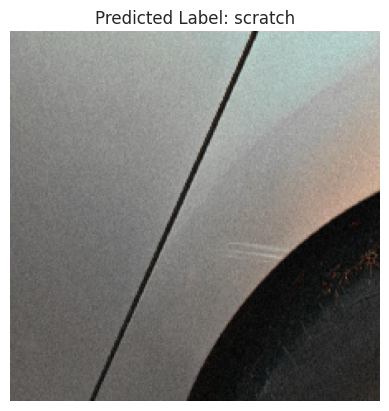

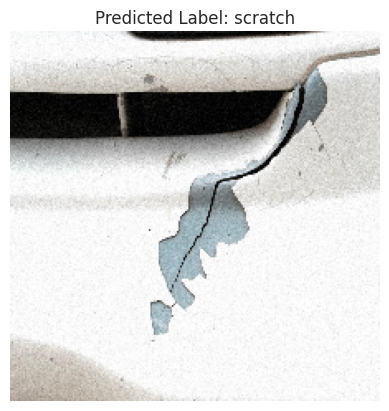

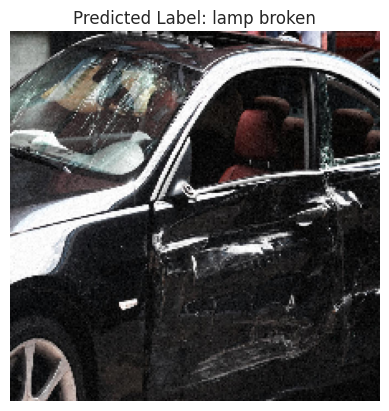

1/1 [==============================] - 0s 27ms/step


In [ ]:
import matplotlib.pyplot as plt


test_images_dir = "/content/test/test/images"
batch_size = 32
img_height, img_width = 224, 224

# Create custom test data generator
test_generator = CustomTestDataGenerator(test_images_dir, batch_size, img_height, img_width)


count = 0


for i in range(len(test_generator)):
    batch_images = test_generator[i]
    batch_predictions = cnn_model.predict(batch_images)

    # Iterate over images in batch
    for j in range(len(batch_images)):
        if count >= 3:
            break

        image = batch_images[j]
        prediction = np.argmax(batch_predictions[j])
        predicted_label = label_to_cls.get(prediction + 1, "Unknown")

        # Display image and predicted label
        plt.imshow(image)
        plt.title(f"Predicted Label: {predicted_label}")
        plt.axis('off')
        plt.show()

        count += 1


## Model 1: ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without top (fully connected) layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

# Create ResNet model
resnet_model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
resnet_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Display model summary
resnet_model.summary()

# Define data generators
train_images_dir = "/content/train/train/images"
batch_size = 32
img_height, img_width = 224, 224

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_images_dir,
    x_col="filename",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw'  # 'raw' for sparse categorical labels
)

# Fit the CNN model
resnet_model.fit(train_generator, epochs=10)

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

1/1 [==============================] - 1s 1s/step


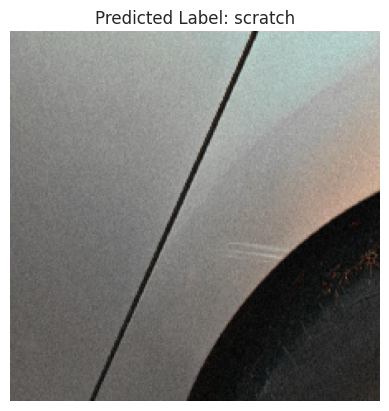

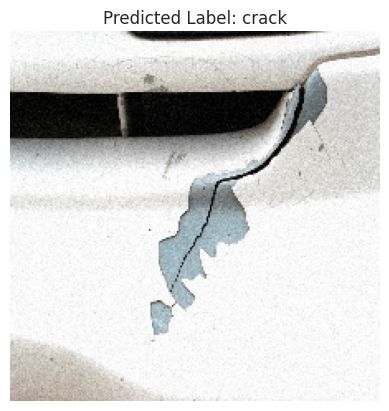

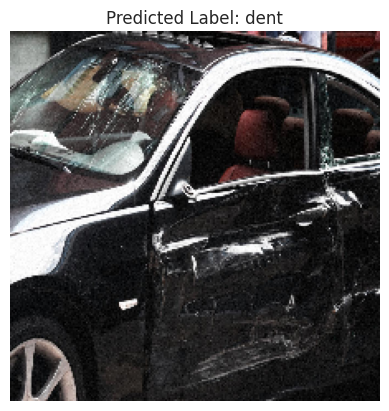

1/1 [==============================] - 0s 30ms/step


In [ ]:
import matplotlib.pyplot as plt

# Mapping of class index to label
label_to_cls = {1: "crack", 2: "scratch", 3: "tire flat", 4: "dent", 5: "glass shatter", 6: "lamp broken"}


count = 0


for i in range(len(test_generator)):
    batch_images = test_generator[i]
    batch_predictions = resnet_model.predict(batch_images)


    for j in range(len(batch_images)):
        if count >= 3:
            break

        image = batch_images[j]
        prediction_resnet = np.argmax(batch_predictions[j])


        predicted_label = label_to_cls.get(prediction_resnet + 1, "Unknown")

        # Display image and predicted label
        plt.imshow(image)
        plt.title(f"Predicted Label: {predicted_label}")
        plt.axis('off')
        plt.show()

        count += 1


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, csv_file, images_dir, batch_size, img_height, img_width, validation_split=0.1):
        self.csv_file = csv_file
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.validation_split = validation_split
        self.df = pd.read_csv(csv_file)
        self.train_df, self.val_df = train_test_split(self.df, test_size=validation_split, random_state=42)
        self.num_train_samples = len(self.train_df)
        self.num_val_samples = len(self.val_df)

    def __len__(self):
        return int(np.ceil(self.num_train_samples / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, self.num_train_samples)

        batch_data = self.train_df.iloc[start_index:end_index]
        batch_images = []
        batch_labels = []

        for _, row in batch_data.iterrows():
            image_path = row['filename']
            label = row['label']

            # Load and preprocess image
            image = load_img(os.path.join(self.images_dir, image_path), target_size=(self.img_height, self.img_width))
            image = img_to_array(image) / 255.0

            batch_images.append(image)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)

    def validation_generator(self):
        while True:
            for index in range(0, self.num_val_samples, self.batch_size):
                batch_data = self.val_df.iloc[index:index+self.batch_size]
                batch_images = []
                batch_labels = []

                for _, row in batch_data.iterrows():
                    image_path = row['filename']
                    label = row['label']

                    # Load and preprocess image
                    image = load_img(os.path.join(self.images_dir, image_path), target_size=(self.img_height, self.img_width))
                    image = img_to_array(image) / 255.0

                    batch_images.append(image)
                    batch_labels.append(label)

                yield np.array(batch_images), np.array(batch_labels)


train_csv_file = "/content/train/train/train.csv"
train_images_dir = "/content/train/train/images"
batch_size = 32
img_height, img_width = 224, 224

train_generator = CustomDataGenerator(train_csv_file, train_images_dir, batch_size, img_height, img_width)
validation_generator = train_generator.validation_generator()


## Model 2: EfficientNetB0

In [6]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Define paths and parameters
train_csv_file = "/content/train/train/train.csv"
train_images_dir = "/content/train/train/images"
validation_split = 0.1
batch_size = 32
img_height, img_width = 224, 224
num_classes = 6

# Read CSV file
labels_df = pd.read_csv(train_csv_file)

# Convert integer labels to strings
labels_df['label'] = labels_df['label'].astype(str)

# Split data into train and validation sets
train_df, val_df = train_test_split(labels_df, test_size=validation_split, random_state=42)

# Define data generators for training and validation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_images_dir,
    x_col="filename",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'  # 'sparse' for sparse categorical labels
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_images_dir,
    x_col="filename",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'  # 'sparse' for sparse categorical labels
)

# Load pre-trained EfficientNet model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Customize the model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile the model
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5',
                                   monitor='val_loss',
                                   save_best_only=True)

# Train the model
history = model_2.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    callbacks=[early_stopping, model_checkpoint])


Found 6480 validated image filenames belonging to 6 classes.
Found 720 validated image filenames belonging to 6 classes.
16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/10
203/203 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.7338

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/203 [==============================] - 186s 702ms/step - loss: 0.7018 - accuracy: 0.7338 - val_loss: 1.7744 - val_accuracy: 0.2972
Epoch 2/10
203/203 [==============================] - 138s 678ms/step - loss: 0.3727 - accuracy: 0.8648 - val_loss: 2.2905 - val_accuracy: 0.2972
Epoch 3/10
203/203 [==============================] - 137s 677ms/step - loss: 0.2651 - accuracy: 0.9029 - val_loss: 3.1757 - val_accuracy: 0.2972
Epoch 4/10
203/203 [==============================] - 138s 677ms/step - loss: 0.2038 - accuracy: 0.9295 - val_loss: 3.1692 - val_accuracy: 0.2639


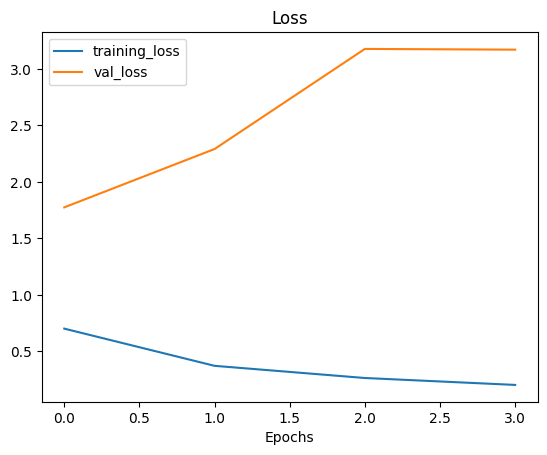

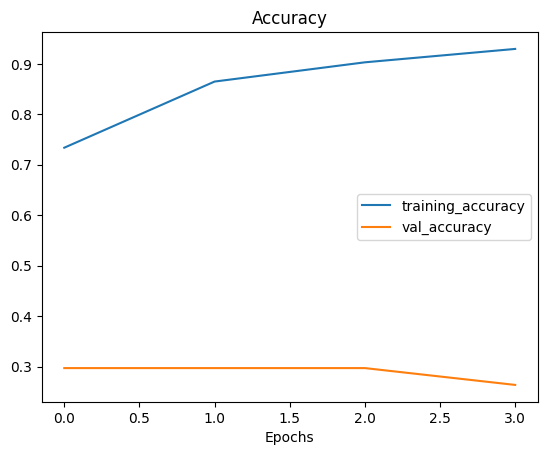

In [7]:
plot_loss_curves(history)

1/1 [==============================] - 2s 2s/step


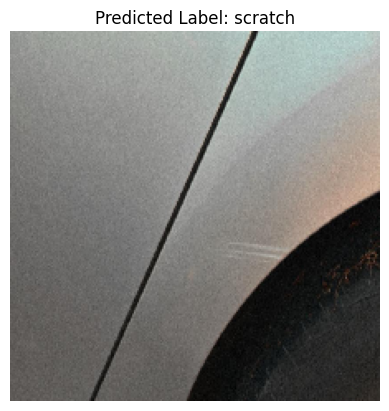

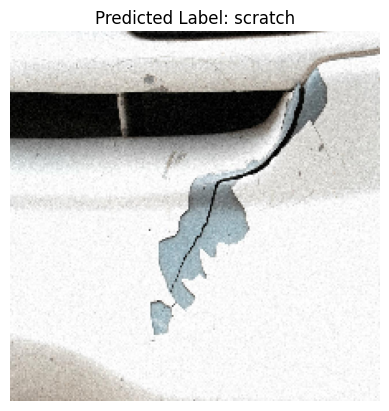

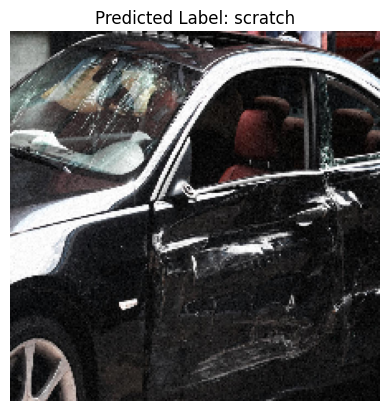

1/1 [==============================] - 0s 53ms/step


In [11]:
import matplotlib.pyplot as plt

# Mapping of class index to label
label_to_cls = {1: "crack", 2: "scratch", 3: "tire flat", 4: "dent", 5: "glass shatter", 6: "lamp broken"}


count = 0


for i in range(len(test_generator)):
    batch_images = test_generator[i]
    batch_predictions = model_2.predict(batch_images)


    for j in range(len(batch_images)):
        if count >= 3:
            break

        image = batch_images[j]
        prediction_efficientnet = np.argmax(batch_predictions[j])


        predicted_label = label_to_cls.get(prediction_efficientnet + 1, "Unknown")

        # Display image and predicted label
        plt.imshow(image)
        plt.title(f"Predicted Label: {predicted_label}")
        plt.axis('off')
        plt.show()

        count += 1


## Conclusion

The best prediction performance is `model_1` using `ResNet50`.